In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import rasterio

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


In [2]:
from scipy.stats import mode 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
processed_table = 'santiago_unidadesvecinales_hqsl_4_5_kmh'
gdf = aup.gdf_from_db(processed_table, 'projects_research')
print(gdf.shape)
gdf.head(2)

(1088, 275)


,NOMBRE_REG,CODIGO_REG,NOMBRE_COM,CUT,NOMBRE_UV,CODIGO_UV,PORC_VIV,COD_UNICO_,PERSONAS,HOMBRE,...,culture_count,greenspace_count,entertainment_count,enjoying_count,education_count,learning_count,workplaces_count,sustainable_mobility_count,working_count,hqsl
0,METROPOLITANA DE SANTIAGO,13,SANTIAGO,13101,1,1,100.0,13101_1,4198,2125,...,34.641814,8.445386,28.359327,9.085061,43.581838,5.559616,6.211292,28.835471,7.144437,42.558339
1,METROPOLITANA DE SANTIAGO,13,SANTIAGO,13101,10,10,100.0,13101_10,5009,2439,...,6.912039,7.555781,8.876800,2.918078,42.068591,5.258574,7.007268,20.664400,5.534334,28.390983


In [52]:
query = 'SELECT * FROM projects_research.santiago_hexproximity_hqsl_4_5_kmh_pub WHERE res = 9'
gdf = aup.gdf_from_query(query)

# Show
print(gdf.shape)
gdf.head(1)

(9121, 201)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,culture_count,greenspace_count,entertainment_count,enjoying_count,education_count,learning_count,workplaces_count,sustainable_mobility_count,working_count,hqsl
0,89b2c55085bffff,"POLYGON ((-70.79572 -33.40004, -70.79689 -33.4...",69.564997,0.001,53.321742,0.001,63.057446,0.001,173.61823,0.001,...,0.0,4.8333,7.238974,1.509034,0.0,0.0,0.0,0.0,0.0,3.155563


In [5]:
gdf = gpd.read_file('../../../data/processed/santiago/santiago_unidadesvecinales_hqsl_4_5_kmh_utm.gpkg')
print(gdf.shape)
gdf.head(2)

(1074, 276)


,NOMBRE_REG,CODIGO_REG,NOMBRE_COM,CUT,NOMBRE_UV,CODIGO_UV,PORC_VIV,COD_UNICO_,PERSONAS,HOMBRE,...,entertainment_count,enjoying_count,education_count,learning_count,workplaces_count,sustainable_mobility_count,working_count,hqsl,area_ha,geometry
0,METROPOLITANA DE SANTIAGO,13,SANTIAGO,13101,1,1,100.0,13101_1,4198,2125,...,28.359327,9.085061,43.581838,5.559616,6.211292,28.835471,7.144437,42.558339,33.905364,"POLYGON ((347955.391 6299217.045, 347957.500 6..."
1,METROPOLITANA DE SANTIAGO,13,SANTIAGO,13101,10,10,100.0,13101_10,5009,2439,...,8.876800,2.918078,42.068591,5.258574,7.007268,20.664400,5.534334,28.390983,22.810436,"POLYGON ((344106.286 6300161.096, 344106.508 6..."


In [15]:
gdf['area_ha'] = gdf.to_crs("EPSG:32719").area / 10000
gdf['PERSONAS'] = gdf['PERSONAS'].astype('float64')
gdf['dens_pobha'] = gdf['PERSONAS'] / gdf['area_ha']

In [5]:
source_list = ['supermercado','clinica_priv','clinica_pub',
                   'hospital_priv','hospital_pub',
                   'consult_ado_priv','consult_ado_pub',
                   'club_deportivo','eq_deportivo_pub','eq_deportivo_priv',
                   'tax_collection','civic_office','social_security',
                   'museos_priv','museos_pub','sitios_historicos',
                   'cines','edu_basica_priv',
                   'edu_basica_pub','edu_media_priv','edu_media_pub',
                   'jardin_inf_priv','jardin_inf_pub','edu_especial_priv',
                   'edu_especial_pub','bibliotecas','agua_alcantarillado',
                   'residencia_adumayor','paradas_tp','paradas_tp_tren',
                   'paradas_tp_metro', 'banco','carniceria','farmacia',
                   'hogar', 'librerias','local_mini_market','bakeries',
                   'restaurantes_bar_cafe', 'universidad', 'edu_tecnica',
                   'edu_adultos_priv','edu_adultos_pub','centro_edu_amb',
                   'centro_recyc', 'labs_priv', 'salud_mental', 'bomberos',
                   'correos', 'police', 'vacunatorio_pub', 'vacunatorio_priv',
                   'eleam', 'ferias', 'ciclovias','ep_plaza_small','ep_plaza_big',
               'ndvi_count', 'hotel_count', 'viv_count','viv_social_count',
              'working','caring','learning','supplying','enjoying','living',
              'hqsl']

In [6]:
# --- REQUIRED DATA: parameters dictionary
# Structure: {social_functions:{themes:[source_names]}}

parameters_dict = {'supplying':{'groceries':['carniceria','hogar','local_mini_market',
                                             'bakeries','ferias','supermercado'],
                                'services':['centro_recyc'],
                               },
                   'caring':{'health':['clinica_priv','clinica_pub',
                                       'hospital_priv','hospital_pub',
                                       'vacunatorio_priv','vacunatorio_pub',
                                       'consult_ado_priv','consult_ado_pub',
                                       'salud_mental','labs_priv','residencia_adumayor','farmacia'],
                             'public_wellbeing':['bomberos'],
                             'exercise':['club_deportivo','eq_deportivo_pub','eq_deportivo_priv']
                            },
                   'living':{'errands_paperwork':['civic_office','tax_collection',
                                                  'social_security','correos','banco'],
                             'housing':['viv_count','viv_social_count'],
                             'public_services':['police'],
                             'fresh_air':['ep_plaza_small','ep_plaza_big'],
                             'temporary_residence':['hotel_count']
                            },
                   'enjoying':{'culture':['museos_priv','museos_pub','bibliotecas','sitios_historicos'],
                               'greenspace':['ndvi_count'],
                               'entertainment':['cines','librerias','restaurantes_bar_cafe']
                              },
                   'learning':{'education':['jardin_inf_pub',#'jardin_inf_priv',
                                            'edu_especial_pub',#'edu_especial_priv',
                                            'edu_basica_pub',#'edu_basica_priv',
                                            'edu_media_pub',#'edu_media_priv',
                                            'edu_tecnica','universidad',
                                            'edu_adultos_pub',#'edu_adultos_priv',
                                            'centro_edu_amb']
                              },
                   'working':{'workplaces':['oficinas_count'],
                              'sustainable_mobility':['ciclovias','paradas_tp',
                                                      'paradas_tp_tren','paradas_tp_metro']}
                  }

## Define analysis variables

In [53]:
social_fn = 'living'

In [54]:
col_analysis = []

for theme in parameters_dict[social_fn]:
    for source in parameters_dict[social_fn][theme]:
            
        for col in gdf.columns:
            if source in col and '_time' in col:
                col_analysis.append(col)
            if source in col and '_count' in col and 'scaled' not in col:
                col_analysis.append(col)

# col_analysis.append('dens_pobha')
col_analysis = list(set(col_analysis))
col_analysis

['banco_count_15min',
 'correos_count_15min',
 'tax_collection_count_15min',
 'ep_plaza_big_count_15min',
 'police_time',
 'civic_office_count_15min',
 'ep_plaza_big_time',
 'correos_time',
 'viv_social_count',
 'ep_plaza_small_count_15min',
 'viv_count',
 'tax_collection_time',
 'social_security_count_15min',
 'ep_plaza_small_time',
 'social_security_time',
 'banco_time',
 'police_count_15min',
 'civic_office_time',
 'hotel_count']

## K-means model

Fill missing values

In [55]:
gdf = gdf.fillna(0)

Data to numpy array

In [56]:
data = gdf[col_analysis].to_numpy()

Standarize data

In [57]:
scaler = StandardScaler()

data = scaler.fit_transform(data)
data.shape

(9121, 19)

Split data

In [58]:
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(data, gdf[['hqsl']].to_numpy(), test_size = 0.15)

### Model

{4: 0.18563431485895135, 5: 0.20748889486473554, 6: 0.18059403071887542, 7: 0.19294935137955632, 8: 0.2320108123056967, 9: 0.2161186587094167, 10: 0.20757275046994517, 11: 0.20972919567049256, 12: 0.21166641190957775, 13: 0.21966270656724687, 14: 0.22248673468755098, 15: 0.22549329856458503, 16: 0.21999343140415592, 17: 0.21510389340959601, 18: 0.21673957728114931, 19: 0.21448469101387643}


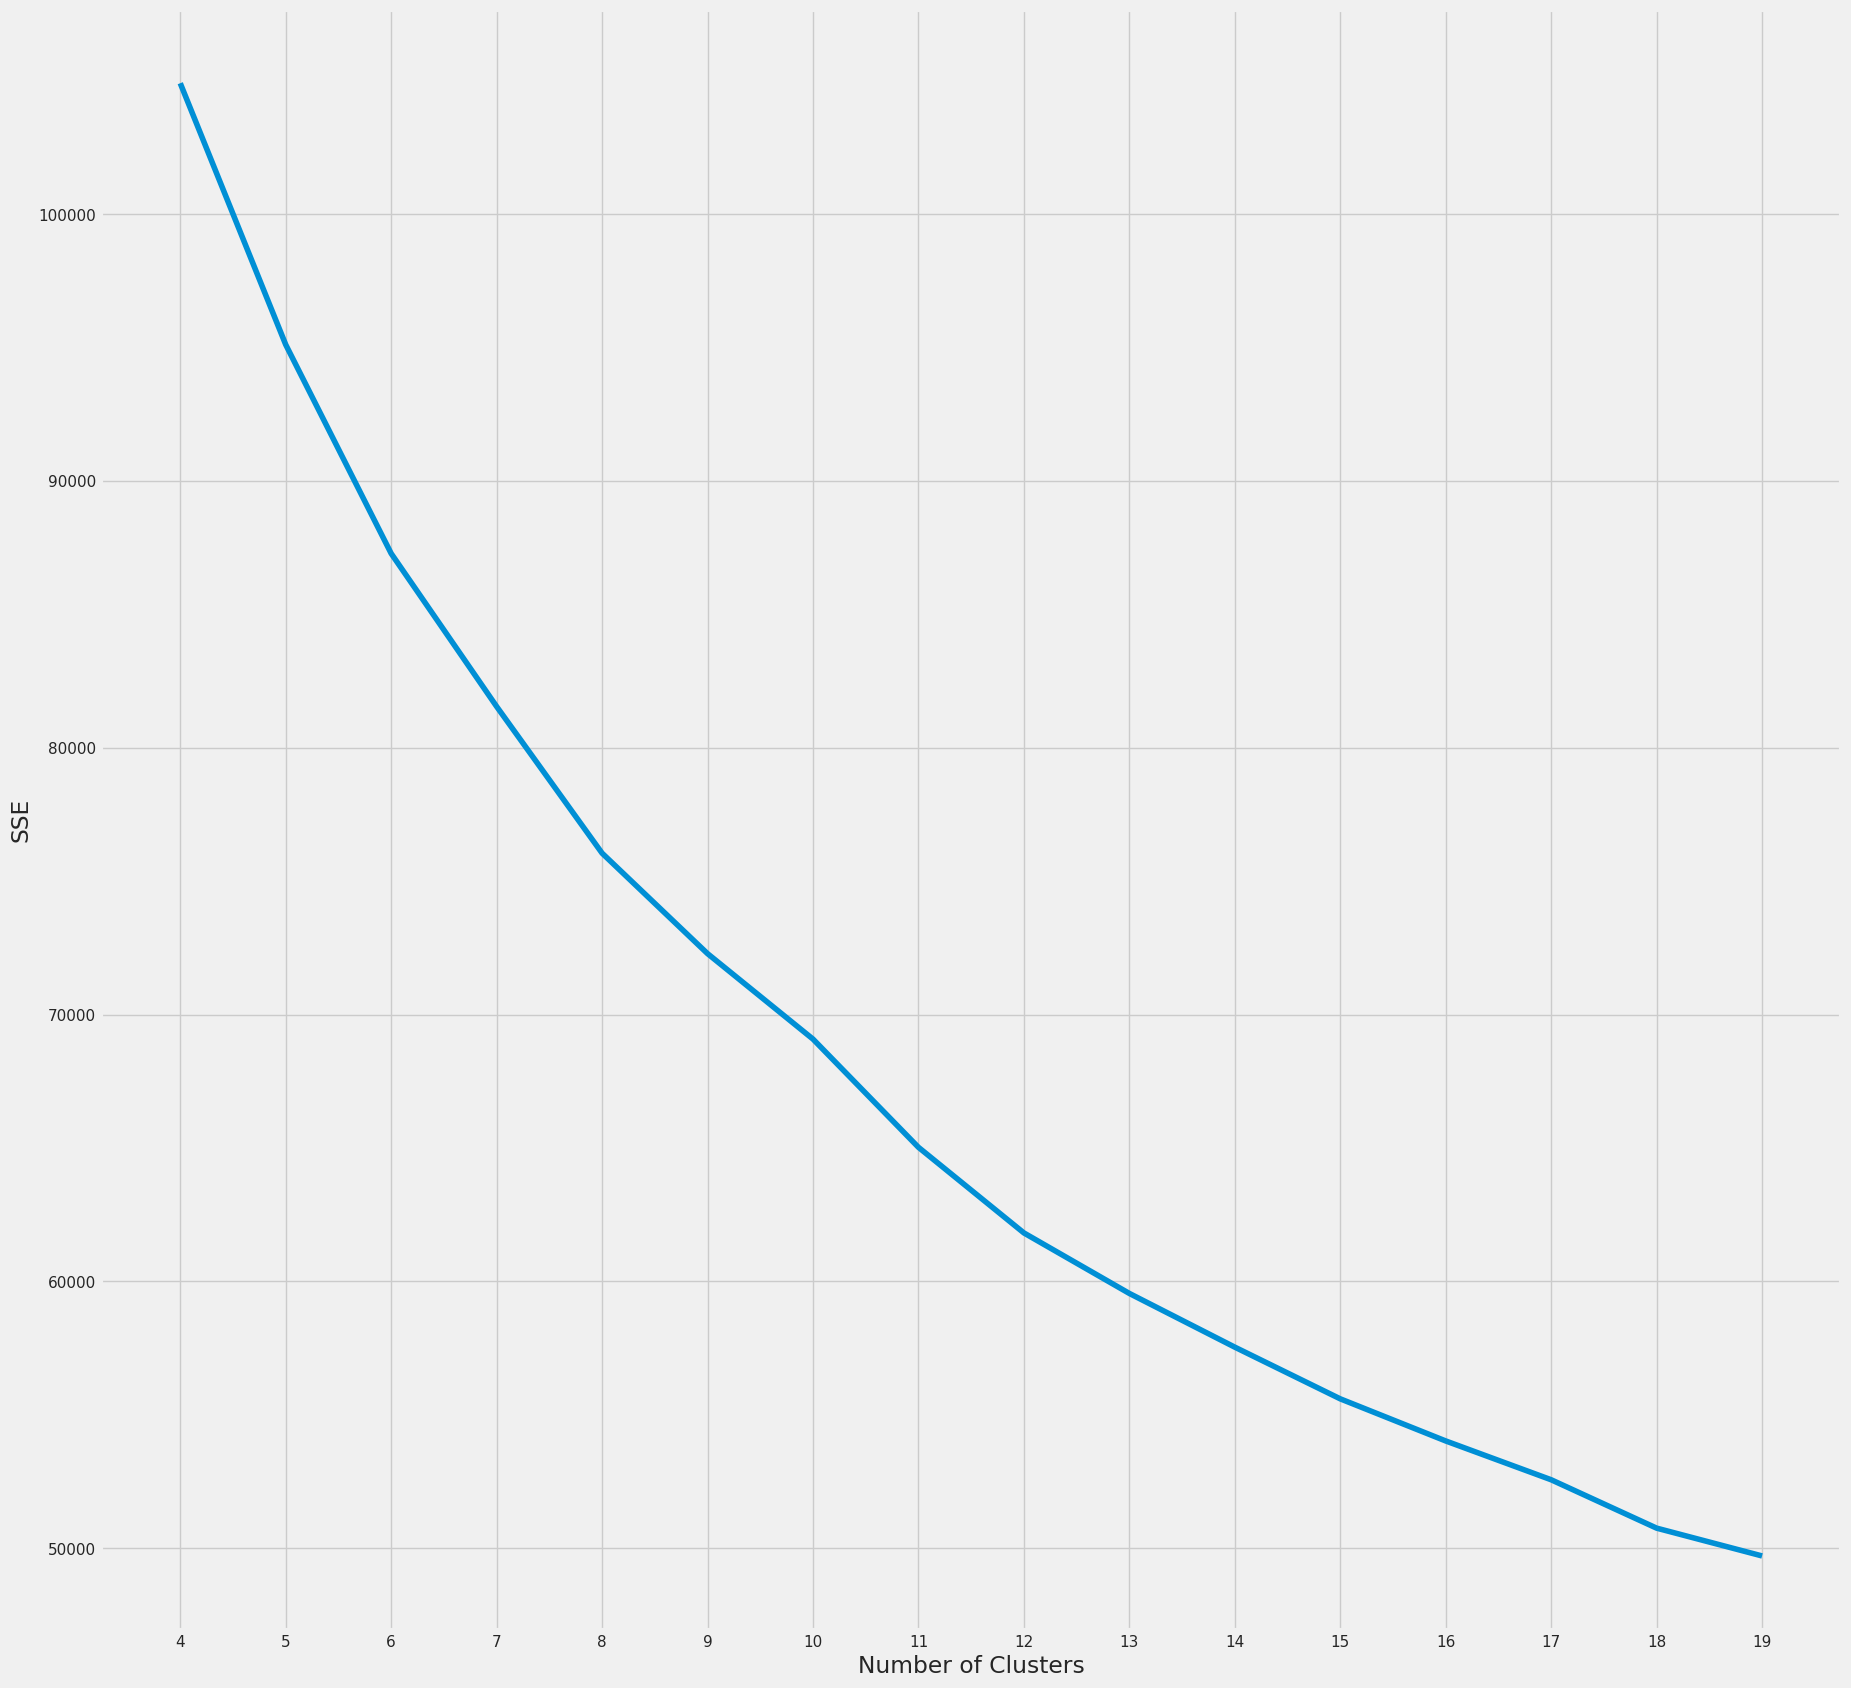

In [59]:
# Elbow curve to find optimal K 
kmeans_kwargs = {
    "init": "random",
    "n_init": 30,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
silhouette_avg = {}
start_kmeans = 4
end_kmeans = 20

for k in range(start_kmeans, end_kmeans):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(data)
    sse.append(kmeans.inertia_)
    silhouette_avg[k] = silhouette_score(data, cluster_labels)
    # print(k,silhouette_score(data, cluster_labels))
    

print(silhouette_avg)

plt.style.use("fivethirtyeight")
plt.plot(range(start_kmeans, end_kmeans), sse)
plt.xticks(range(start_kmeans, end_kmeans))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Plot data

In [60]:
# 9 categorías de zonificación

kmeans = KMeans(
    init="random",
    n_clusters=20,
    n_init=30,
    max_iter=300,
    random_state=42
)
clusters = kmeans.fit_predict(data) 
clusters

array([18,  7,  1, ..., 11,  3,  2], dtype=int32)

<AxesSubplot: >

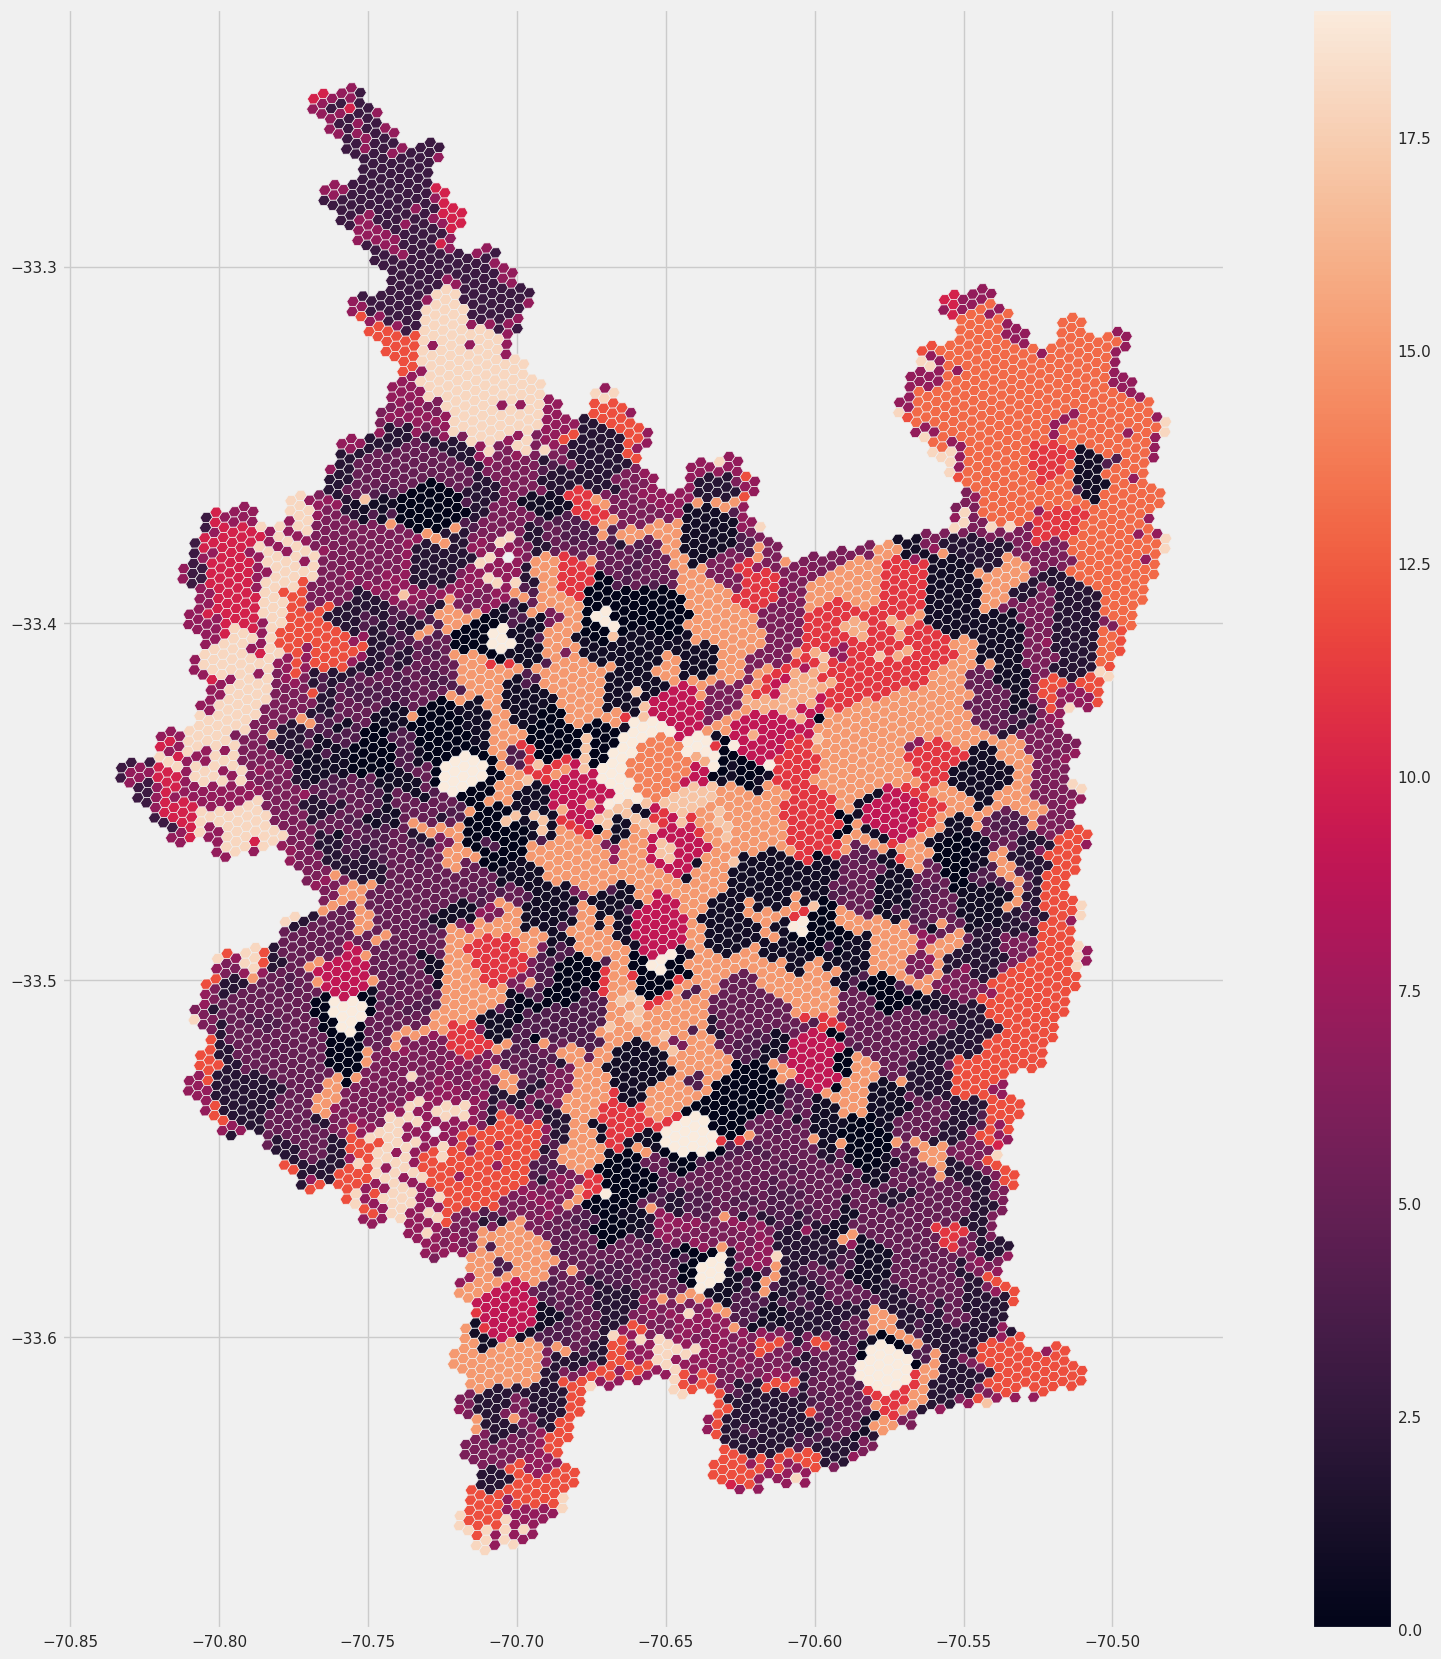

In [61]:
gdf['cluster'] = clusters
gdf.plot('cluster', legend=True)

Statistics

In [62]:
col_cluster = col_analysis
col_cluster.append('cluster')
col_cluster = list(set(col_cluster))

for c in gdf[col_cluster].columns:
    if gdf[c].dtypes == 'object':
        gdf[c] =  gdf[c].astype('float64')

In [63]:

gdf[col_cluster].groupby('cluster').mean()

,banco_count_15min,correos_count_15min,tax_collection_count_15min,ep_plaza_big_count_15min,police_time,civic_office_count_15min,ep_plaza_big_time,correos_time,viv_social_count,ep_plaza_small_count_15min,viv_count,tax_collection_time,social_security_count_15min,ep_plaza_small_time,social_security_time,banco_time,police_count_15min,civic_office_time,hotel_count
cluster,,,,,,,,,,,,,,,,,,,
0,1.530986,0.296671,0.003587,5.294809,16.186378,2.711074,6.169580,23.811654,1.417531,30.964613,15.221978,61.918703,1.062345,2.922890,10.103785,14.109263,0.518683,8.803019,1.668638
1,1.580563,0.114285,0.004973,5.476614,9.570162,0.924065,5.098817,29.630797,0.745329,22.971001,12.695487,64.137138,0.031524,3.679250,33.734119,13.284840,1.228287,18.254145,1.977931
2,0.330074,0.002622,0.001000,4.313792,31.855792,0.011947,5.145456,49.826528,0.456007,27.351137,9.367988,106.261976,0.001192,2.867215,51.769572,28.993632,0.077724,39.838997,0.738210
3,0.001000,0.001000,0.001000,0.225908,128.403651,0.001000,41.489557,136.155832,0.001000,0.971720,0.545492,247.971181,0.001000,27.107636,136.334997,84.084537,0.001000,131.314021,0.059316
4,0.380435,0.070223,0.001501,6.183560,20.089881,0.557280,4.621251,33.155595,12.589024,36.737881,16.459423,79.683022,0.105181,2.317566,31.761619,22.144434,0.368018,23.510851,0.189280
5,0.704367,0.033928,0.003829,7.554781,23.369093,0.171348,4.296338,36.689186,1.284223,54.406152,11.529179,70.343254,0.025329,1.714717,33.489245,19.279373,0.217550,25.373587,0.340120
6,0.460782,0.012323,0.001000,1.076258,38.349921,0.046252,14.110225,45.286180,0.029675,3.443855,2.884118,97.910200,0.002103,14.440412,51.912645,24.350250,0.011739,36.617767,1.452524
7,0.001000,0.001000,0.001000,0.001000,0.000000,0.001000,0.000000,0.000000,0.001000,0.001000,0.001000,0.000000,0.001000,0.000000,0.000000,0.000000,0.001000,0.000000,0.001000
8,43.657250,2.094750,0.188500,12.282250,39.875692,0.532250,3.071952,10.534883,0.001000,11.626000,21.675752,17.102076,0.532250,1.956322,13.906523,2.127513,0.001000,13.906523,2399.941576


In [64]:
gdf[col_cluster].groupby('cluster').std()

,banco_count_15min,correos_count_15min,tax_collection_count_15min,ep_plaza_big_count_15min,police_time,civic_office_count_15min,ep_plaza_big_time,correos_time,viv_social_count,ep_plaza_small_count_15min,viv_count,tax_collection_time,social_security_count_15min,ep_plaza_small_time,social_security_time,banco_time,police_count_15min,civic_office_time,hotel_count
cluster,,,,,,,,,,,,,,,,,,,
0,1.921397,0.418447,0.025555,2.942191,7.256410,1.386678,3.738566,12.716639,2.551074,15.719304,10.550199,33.980236,0.342424,1.885107,3.345552,6.765445,0.545566,3.321551,8.821947
1,1.754260,0.289013,0.035524,2.695929,3.346466,1.255179,3.057954,11.805414,1.687142,12.965676,9.248045,33.358656,0.121269,2.492615,16.671727,7.016958,0.505398,10.259791,12.777000
2,0.913006,0.023651,0.000000,2.317392,12.909174,0.102544,3.610034,15.114910,1.321997,12.250242,7.167168,36.080630,0.004372,1.990069,15.481863,12.938974,0.238801,12.775021,9.375530
3,0.000000,0.000000,0.000000,0.544107,22.575738,0.000000,22.052062,18.543768,0.000000,2.270212,2.598060,34.000026,0.000000,13.505540,20.497548,20.582893,0.000000,19.557347,0.733172
4,0.705108,0.235575,0.010546,3.029984,9.796117,0.944327,3.186275,13.501461,5.884304,16.806376,6.099904,33.451617,0.289724,1.724133,15.910062,10.194050,0.475096,11.998909,1.190629
5,1.141602,0.158462,0.032567,3.374713,10.649918,0.459316,2.883252,13.374600,2.061779,13.557438,5.388221,38.181016,0.113998,0.976086,11.629407,9.513289,0.369880,9.350098,3.161400
6,1.244005,0.075029,0.000000,1.127945,11.569328,0.234040,6.254893,15.585940,0.407607,4.850522,5.406149,38.314975,0.020552,6.710931,15.928066,10.799081,0.086404,12.952445,12.954735
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
gdf[col_cluster].groupby('cluster').count()

,banco_count_15min,correos_count_15min,tax_collection_count_15min,ep_plaza_big_count_15min,police_time,civic_office_count_15min,ep_plaza_big_time,correos_time,viv_social_count,ep_plaza_small_count_15min,viv_count,tax_collection_time,social_security_count_15min,ep_plaza_small_time,social_security_time,banco_time,police_count_15min,civic_office_time,hotel_count
cluster,,,,,,,,,,,,,,,,,,,
0,512,512,512,512,512,512,512,512,512,512,512,512,512,512,512,512,512,512,512
1,817,817,817,817,817,817,817,817,817,817,817,817,817,817,817,817,817,817,817
2,866,866,866,866,866,866,866,866,866,866,866,866,866,866,866,866,866,866,866
3,211,211,211,211,211,211,211,211,211,211,211,211,211,211,211,211,211,211,211
4,444,444,444,444,444,444,444,444,444,444,444,444,444,444,444,444,444,444,444
5,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051,1051
6,813,813,813,813,813,813,813,813,813,813,813,813,813,813,813,813,813,813,813
7,699,699,699,699,699,699,699,699,699,699,699,699,699,699,699,699,699,699,699
8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [66]:
import seaborn as sns

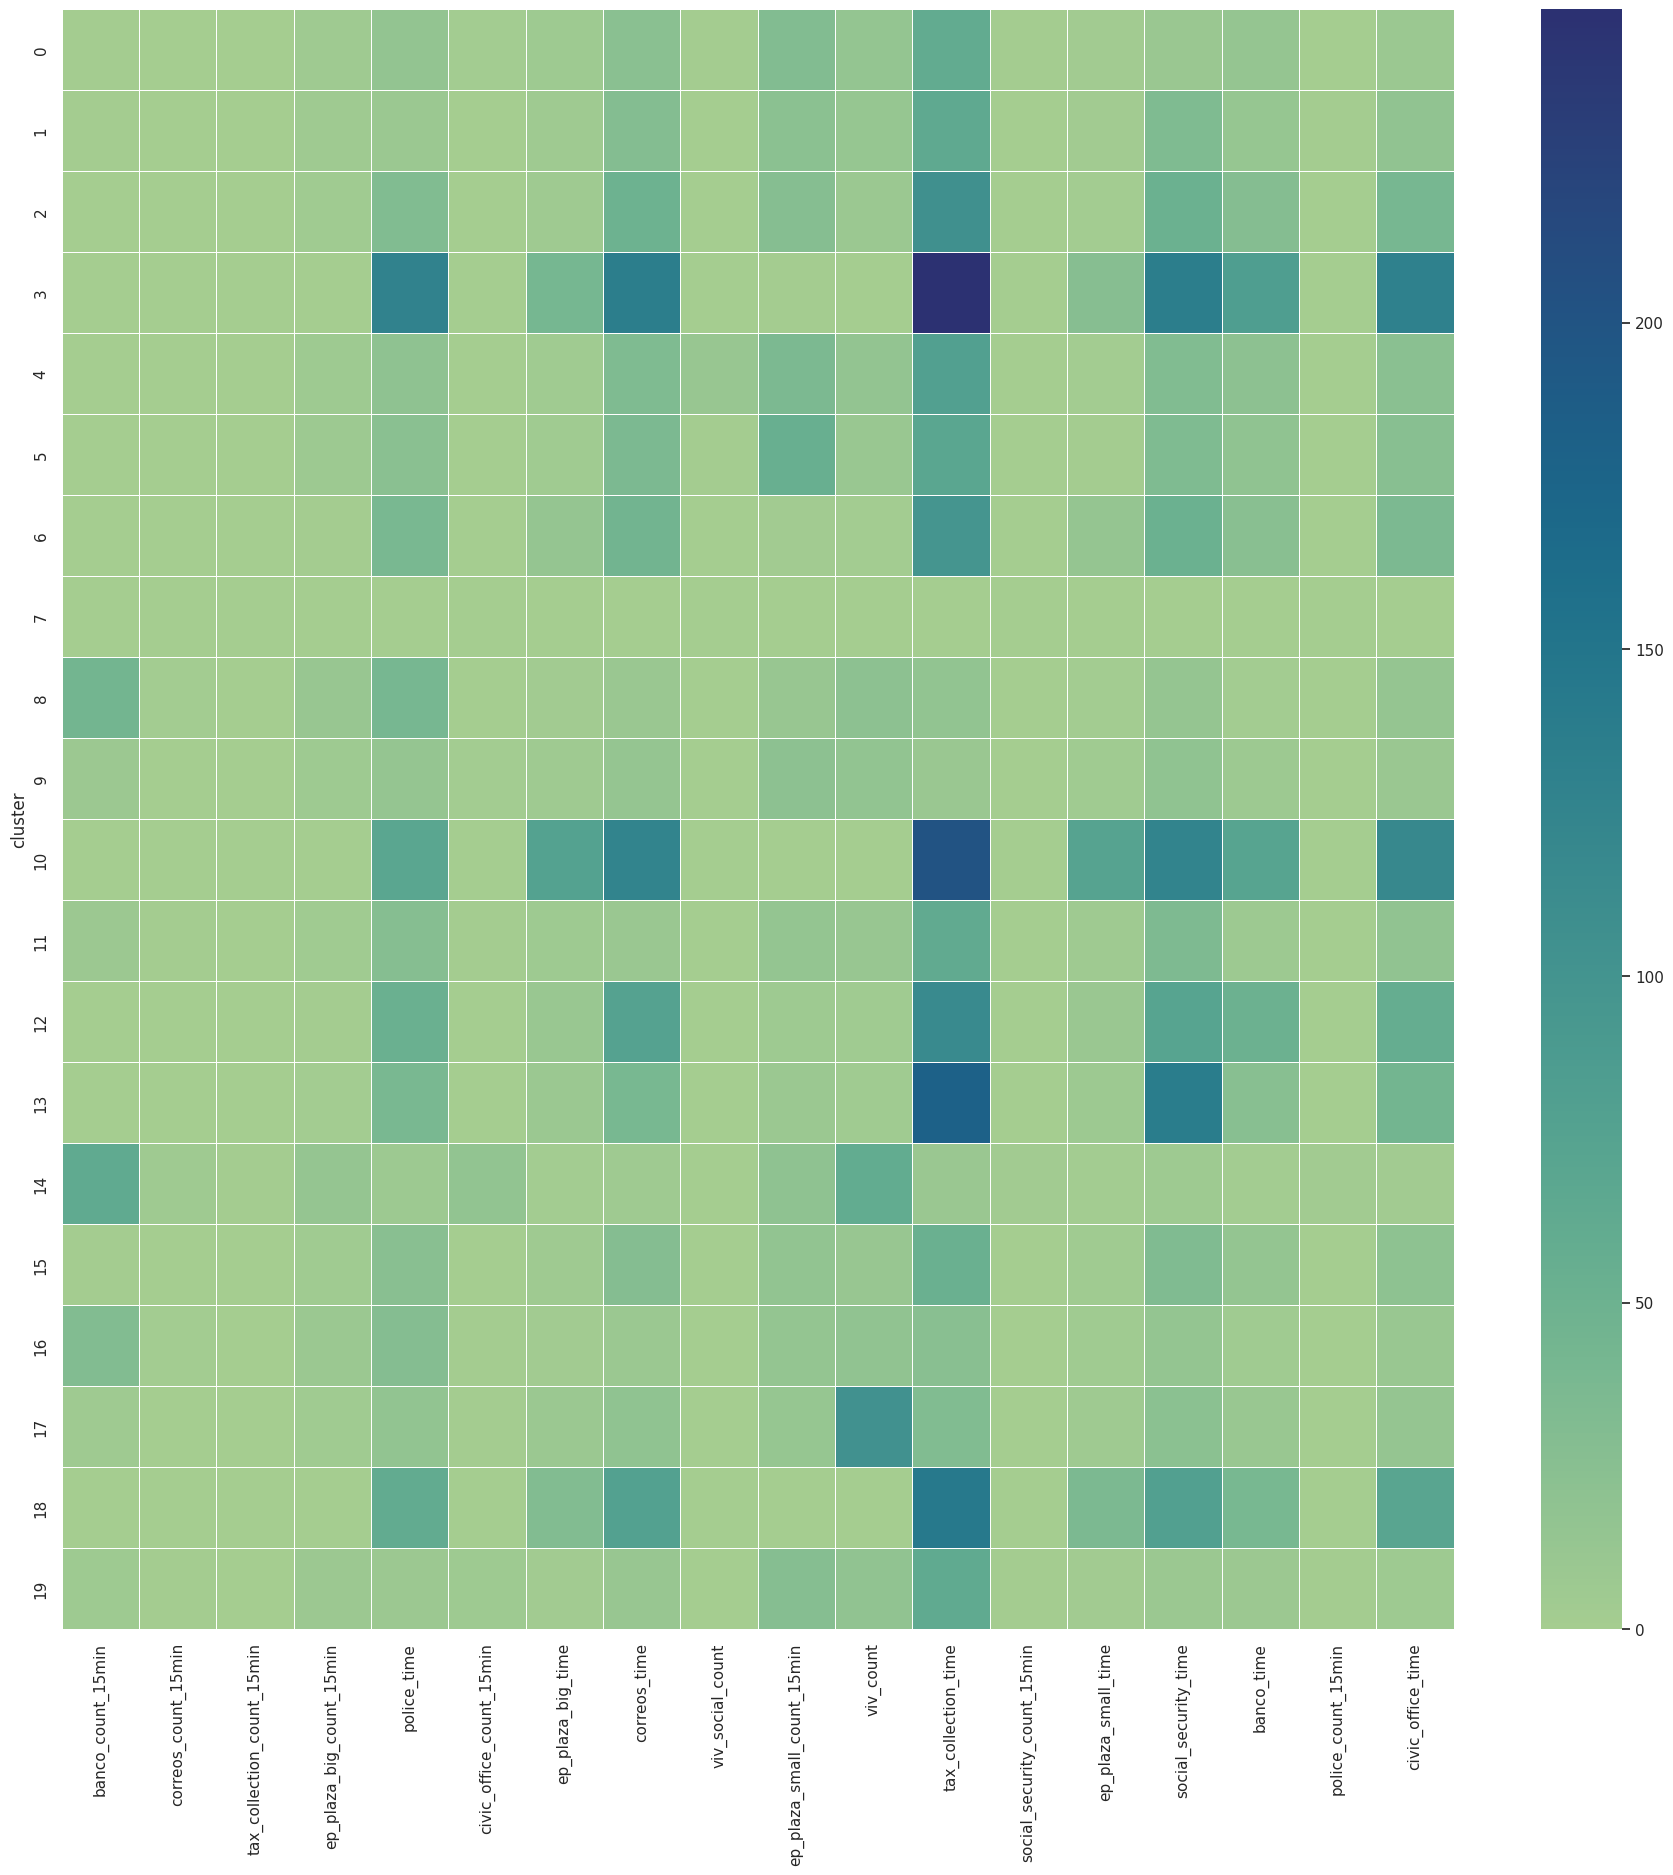

In [70]:
# sns.heatmap(gdf[col_cluster].drop(columns=['dens_pobha']).groupby('cluster').mean(), 
#             annot=False,fmt=".2f", linewidth=.5, cmap="crest")
sns.heatmap(gdf[col_cluster].drop(columns=['hotel_count']).groupby('cluster').mean(), 
            annot=False,fmt=".2f", linewidth=.5, cmap="crest")
sns.set (rc = {'figure.figsize':(20,20)})

In [24]:
gdf.to_file('../../../data/processed/santiago/santiago_unidadesvecinales_cluster_hqsl_4_5_kmh_utm.gpkg')